In [ ]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math as math
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process.kernels import Matern, RationalQuadratic,ExpSineSquared,PairwiseKernel
from tqdm import tqdm
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr

In [3]:
columns = ["x","y","z","w","data","error"]
datatab = pd.read_table("Updateddata.txt",names = columns)
datatab

x = datatab['x']
y = datatab['y']
z = datatab['z']
w = datatab['w']
data = datatab['data']
error = datatab['error']


# First dataset 
datam1 = datatab[0:250]
xm1 = datam1['x'].values
ym1 = datam1['y'].values
zm1 = datam1['z'].values
wm1 = datam1['w'].values
dm1 = datam1['data'].values
em1 = datam1['error'].values
X1 = np.column_stack((xm1, ym1, zm1, wm1))
X1_train, X1_test, D1_train, D1_test, E1_train, E1_test = train_test_split(X1,dm1.reshape(-1, 1),em1.reshape(-1,1),train_size=0.8,random_state=1)

# Second dataset
datam2 = datatab[250:500]
xm2 = datam2['x'].values
ym2 = datam2['y'].values
zm2 = datam2['z'].values
wm2 = datam2['w'].values
dm2 = datam2['data'].values
em2 = datam2['error'].values
X2 = np.column_stack((xm2, ym2, zm2, wm2))
X2_train, X2_test, D2_train, D2_test, E2_train, E2_test = train_test_split(X2, dm2.reshape(-1,1),em2.reshape(-1,1), train_size=0.8, random_state=3)

# Third dataset
datam3 = datatab[500:750]
xm3 = datam3['x'].values
ym3 = datam3['y'].values
zm3 = datam3['z'].values
wm3 = datam3['w'].values
dm3 = datam3['data'].values
em3 = datam3['error'].values
X3 = np.column_stack((xm3, ym3, zm3, wm3))
X3_train, X3_test, D3_train, D3_test,E3_train, E3_test = train_test_split(X3, dm3.reshape(-1,1),em3.reshape(-1,1), train_size=0.8, random_state=5)

# Fourth dataset
datam4 = datatab[750:]
xm4 = datam4['x'].values
ym4 = datam4['y'].values
zm4 = datam4['z'].values
wm4 = datam4['w'].values
dm4 = datam4['data'].values
em4 = datam4['error'].values
X4 = np.column_stack((xm4, ym4, zm4, wm4))
X4_train, X4_test, D4_train, D4_test,E4_train, E4_test = train_test_split(X4, dm4.reshape(-1,1),em4.reshape(-1,1), train_size=0.8, random_state=7)

X = np.column_stack((x,y, z, w))
D = np.concatenate((dm1,dm2,dm3,dm4))
E = np.concatenate((em1,em2,em3,em4))

X_train = np.concatenate((X1_train,X2_train,X3_train,X4_train))
X_test = np.concatenate((X1_test,X2_test,X3_test,X4_test))
D_train = np.concatenate((D1_train,D2_train,D3_train,D4_train))
D_test = np.concatenate((D1_test,D2_test,D3_test,D4_test))
E_train = np.concatenate((E1_train,E2_train,E3_train,E4_train))
E_test = np.concatenate((E1_test,E2_test,E3_test,E4_test))

In [4]:
def MCSGPR(kernel,X_train,D_train,E_train,X1,X1_test,D1_test,n_samples,n_gp_samples):
    posterior_history = []  
    posterior_history_test = [] 
    for sample in tqdm(range(n_samples), desc="Monte Carlo Sampling Progress"):

        ####  This follows the logic since we are saying the error is normally distributed with error 0 and std E_train. There for the error bars which represent 1 standard deviation 
        sampled_D = D_train + np.random.normal(0, E_train)

        gpr = GaussianProcessRegressor(kernel=kernel, normalize_y=True, n_restarts_optimizer = 2,random_state=42)
        gpr.fit(X_train, sampled_D)

        posterior_sample = gpr.sample_y(X1, n_gp_samples,random_state=42)
        posterior_sample_test = gpr.sample_y(X1_test, n_gp_samples,random_state=42)
        posterior_history.append(posterior_sample)  
        posterior_history_test.append(posterior_sample_test)  
    posterior_history = np.array(posterior_history)  
    posterior_history_test = np.array(posterior_history_test) 
    final_mean = np.mean(posterior_history,axis=(0,2))
    final_std = np.std(posterior_history,axis=(0,2))
    final_mean_test = np.mean(posterior_history_test,axis=(0,2))
    final_std_test = np.std(posterior_history_test,axis=(0,2))
    rmse = np.sqrt(mean_squared_error(D1_test, final_mean_test))
    mae = mean_absolute_error(D1_test, final_mean_test)
    r2 = r2_score(D1_test, final_mean_test)
    adjusted_r2 = 1 - (1-r2)*(len(D1_test)-1)/(len(D1_test)-X1_test.shape[1]-1)
    fom = np.mean(np.abs(D1_test - final_mean_test)/final_std_test)
    pearsoncoeff, p_value = pearsonr(D1_test.ravel(), final_mean_test.ravel())

    return final_mean, final_std,final_mean_test,final_std_test,rmse,mae,r2,adjusted_r2,fom,pearsoncoeff

In [5]:
bounds_lmult = ((1e-4, 10), (1e-4, 10.0), (1e-4, 10.0), (1e-4, 10.0))  # Fix l1 bounds
guess_lmult = (1,1,1,1)
bounds_lsingle = (1e-4, 10.0)  
ExpSinelbounds = (1e-2,10)
guess_lsingle = 1.0
guess_signal_var = 1.0
bounds_signal_var = (1e-6,20 )
nu = 1.75
alpha = 1
periodicity = 2
gamma = 1

n_samples = 10  # Number of Monte Carlo samples
n_gp_samples = 20  # Number of function samples per GP



Matkernel = C(constant_value=guess_signal_var, constant_value_bounds=bounds_signal_var) * Matern(length_scale=guess_lmult, length_scale_bounds=bounds_lmult, nu=nu)
Radkernel = C(constant_value=guess_signal_var, constant_value_bounds=bounds_signal_var) * RationalQuadratic(length_scale=guess_lsingle, alpha=alpha, length_scale_bounds=bounds_lsingle)
ExpSinekernel = C(constant_value=guess_signal_var, constant_value_bounds=bounds_signal_var) * ExpSineSquared(length_scale=guess_lsingle, periodicity=periodicity, length_scale_bounds=ExpSinelbounds)
Laplacekernel = C(constant_value=guess_signal_var, constant_value_bounds=bounds_signal_var) * PairwiseKernel(gamma=gamma, metric='laplacian')
RBFkernel = C(constant_value=guess_signal_var, constant_value_bounds=bounds_signal_var) * RBF(length_scale=guess_lmult, length_scale_bounds=bounds_lmult)

kernel_list = [Radkernel, ExpSinekernel, Laplacekernel, RBFkernel,Matkernel]
kernel_names = ['Rational Quadratic', 'ExpSineSquared', 'Laplacian', 'RBF','Matkernel']
dimensions = [3,3,2,5,5]
dimensionnames = [['sigma','alpha','l'],['sigma','l','periodicity'],['sigma','gamma'],['sigma','l1','l2','l3','l4'],['sigma','l1','l2','l3','l4']]

In [6]:
metricmontecarlo = []
for kernel in tqdm(list(kernel_list),total=len(kernel_list)):
    fit,std,fittest,stdtest,rmse,mae,r2,adjusted_r2,fom,pearsoncoeff = MCSGPR(kernel,X_train,D_train,E_train,X1,X1_test,D1_test,n_samples,n_gp_samples)
    metricmontecarlo.append([rmse,mae,r2,adjusted_r2,fom,pearsoncoeff])

  0%|          | 0/5 [00:00<?, ?it/s]c:\Users\seanw\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\seanw\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\seanw\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\seanw\anaconda3\Lib\site-packages\sklea

In [7]:
rmse = [metricmontecarlo[i][0] for i in range(len(metricmontecarlo))]
mae = [metricmontecarlo[i][1] for i in range(len(metricmontecarlo))]
r2 = [metricmontecarlo[i][2] for i in range(len(metricmontecarlo))]
adjusted_r2 = [metricmontecarlo[i][3] for i in range(len(metricmontecarlo))]
fom = [metricmontecarlo[i][4] for i in range(len(metricmontecarlo))]
pearsoncoeff =  [metricmontecarlo[i][5] for i in range(len(metricmontecarlo))]

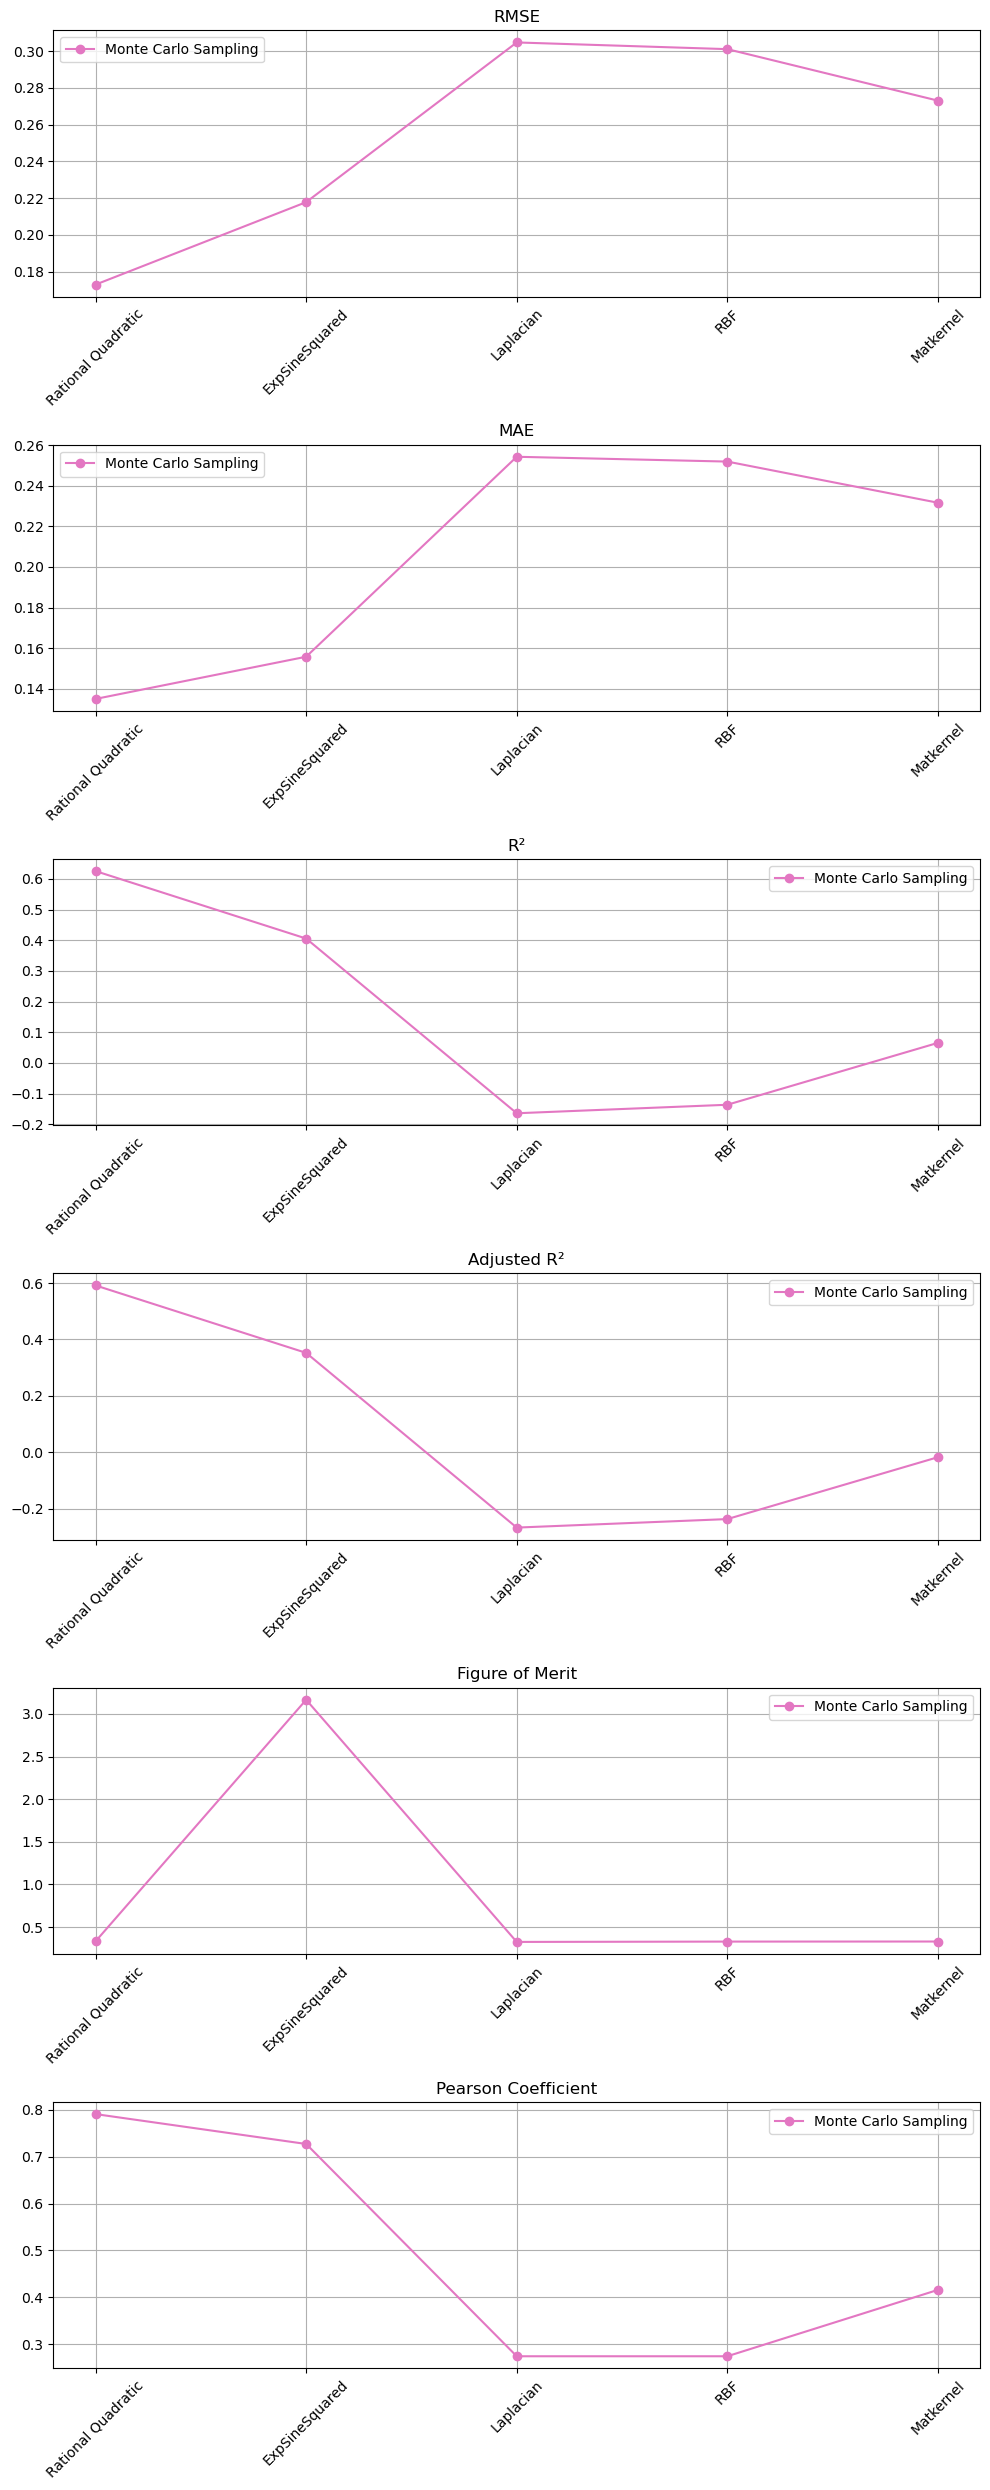

In [8]:
metrics = [rmse, mae, r2, adjusted_r2, fom,pearsoncoeff]
metric_names = ["RMSE", "MAE", "R²", "Adjusted R²", "Figure of Merit","Pearson Coefficient"]

# Distinct colors for the fits (4 colors)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']

fig, axes = plt.subplots(6, 1, figsize=(10, 25))
print()

x = range(len(kernel_names))
x_ticks = np.arange(len(kernel_names))

for i, ax in enumerate(axes):
    ax.plot(x,metrics[i],'-o',label='Monte Carlo Sampling',color=colors[6])
    ax.set_xticks(x_ticks, kernel_names, rotation=45)
    ax.set_title(metric_names[i])
    ax.set_xticks(x)
    ax.grid(True)
    ax.legend(loc='best')

plt.tight_layout()
plt.show()

In [9]:
MonteCarloSamplingMetrics = np.array(metrics)

In [10]:
np.savetxt(r"C:\Users\seanw\OneDrive\Desktop\GitHub\FYP\Final Model Code\ModelMetrics\MonteCarloSamplingMetrics.csv", MonteCarloSamplingMetrics, delimiter=",")